# Work FLow
    1.import Libraries
    2.input embedding
    3.Positional Encoding
    4.Multi Head Attention(Self Attention)
    5.Add & Normalized
    6.Feed Forward
    7.Residual Connection
    8.Encoder
    9.Decoder
    10.Projection layer
    11.Build a Transformer

## 1.import Libraries

In [1]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset,random_split
from torch.utils.tensorboard import SummaryWriter

import math


# 2.Input Embedding

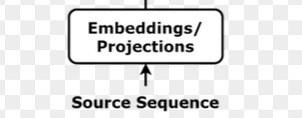

In [2]:
class InputEmbedding(nn.Module):
    def __init__(self,d_model:int,vocab_size:int):
        super().__init__()
        self.d_model=d_model
        self.vocab_size = vocab_size
        self.embedding=nn.Embedding(vocab_size,d_model)
        
    def forward(self,x):
        return self.embedding(x)*math.sqrt(self.d_model)

# 3.Position Encoding 

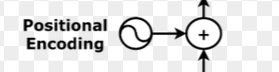

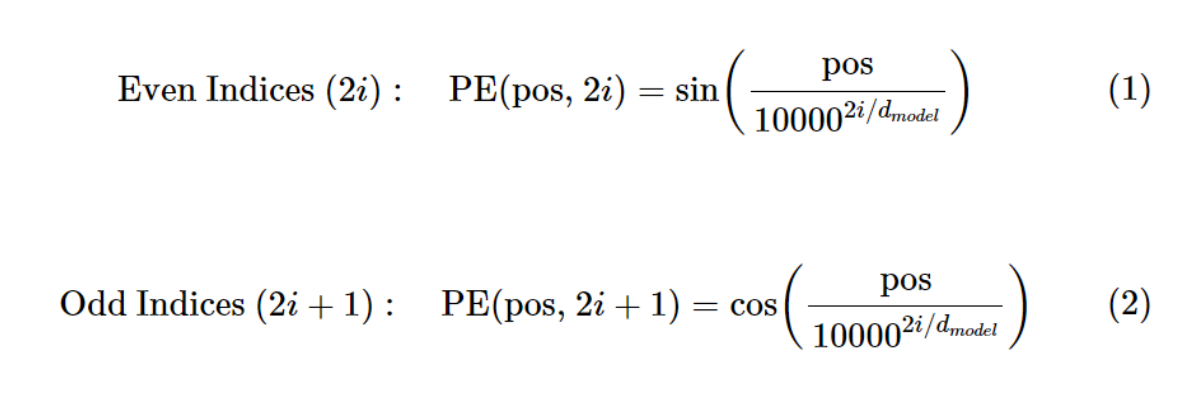

In [3]:
class PositionEncoding(nn.Module): 
    def __init__(self, d_model: int, seq_len: int, dropout: float):
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout)
        
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)  # (seq_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # (1, seq_len, d_model)
        
        self.register_buffer("pe", pe)
        
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

## 4.Multi-Head Attention

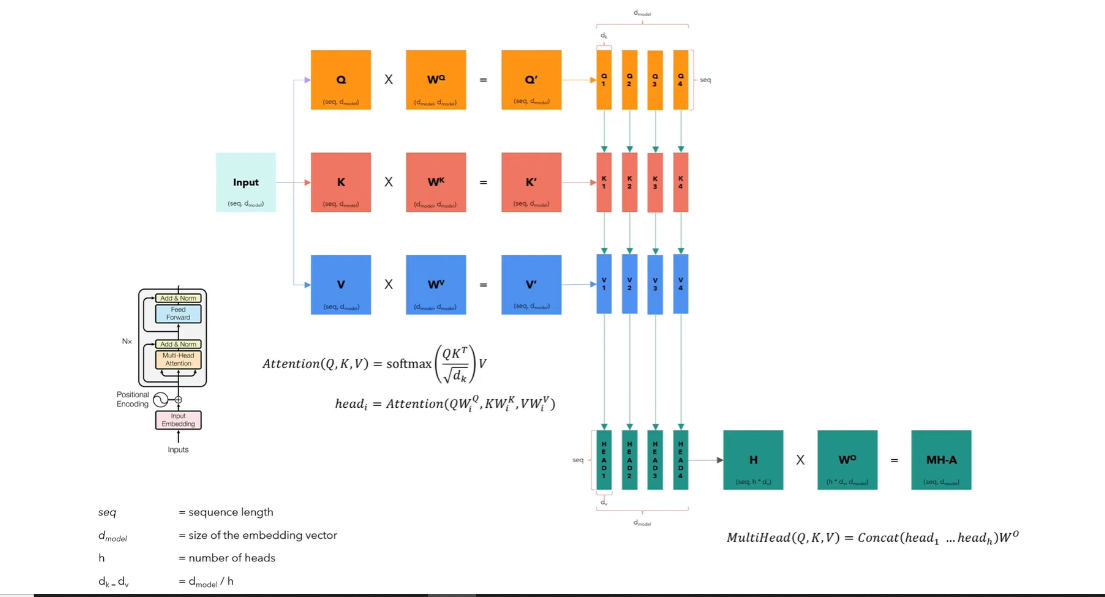

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_model:int,h:int,dropout:float) -> None:
        super().__init__()
        self.d_model=d_model
        self.h=h
        
        assert d_model%h==0,"d_model is not divisible by h"
        
        self.d_k=d_model//h
        
        self.w_q=nn.Linear(d_model,d_model)
        self.w_k=nn.Linear(d_model,d_model)
        self.w_v=nn.Linear(d_model,d_model)
        self.w_o=nn.Linear(d_model,d_model)
        
        self.dropout=nn.Dropout(dropout)
        
    @staticmethod
    def attention(query,key,value,mask,dropout:nn.Dropout):
        d_k=query.shape[-1]
        attention_scores=(query @ key.transpose(-2,-1))/math.sqrt(d_k)
        
        if mask is not None:
            attention_scores = attention_scores.masked_fill(mask == 0, float("-inf"))
        attention_scores=attention_scores.softmax(dim=-1)
        
        if dropout is not None:
            attention_scores=dropout(attention_scores)
            
        return (attention_scores@value),attention_scores
            
    def forward(self,q,k,v,mask):
        query=self.w_q(q)
        key=self.w_k(k)
        value=self.w_v(v)
        
        query=query.view(query.shape[0],query.shape[1],self.h,self.d_k).transpose(1,2)
        key=key.view(key.shape[0],key.shape[1],self.h,self.d_k).transpose(1,2)
        value=value.view(value.shape[0],value.shape[1],self.h,self.d_k).transpose(1,2)
        
        x,self.attention_scores=MultiHeadAttention.attention(query,key,value,mask,self.dropout)
        
        x=x.transpose(1,2).contiguous().view(x.shape[0],-1,self.h*self.d_k)
        
        return self.w_o(x)

## 5. Layer Normalization

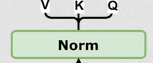

In [5]:
class LayerNormalization(nn.Module):
    def __init__(self,eps:float=10**-6) -> None:
        super().__init__()
        self.eps=eps
        
        self.alpha=nn.Parameter(torch.ones(1))
        
        self.bias=nn.Parameter(torch.zeros(1))
        
    def forward(self,x):
        mean = x.mean(dim=-1,keepdim=True)
        std = x.std(dim=-1,keepdim=True)
        
        return self.alpha*((x-mean)/std+self.eps) + self.bias

## 6.Feed Forward 


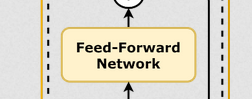

In [6]:
class FeedForward(nn.Module):
    def __init__(self,d_model:int,d_ff:int,dropout:float) -> None:
        super().__init__()
        #First Linear Transformation
        self.linear_1=nn.Linear(d_model,d_ff)
        self.dropout=nn.Dropout(dropout)
        #second Linear Transformation
        self.linear_2=nn.Linear(d_ff,d_model)
        
    def forward(self,x):
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

## 7.Residual Connection

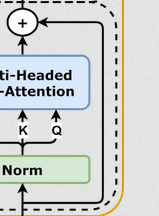

In [7]:
class ResidualConnection(nn.Module):
    def __init__(self,dropout:float) ->None:
        super().__init__()
        self.dropout=nn.Dropout(dropout)
        self.norm=LayerNormalization()
        
    def forward(self,x,sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

## 8.Encoder

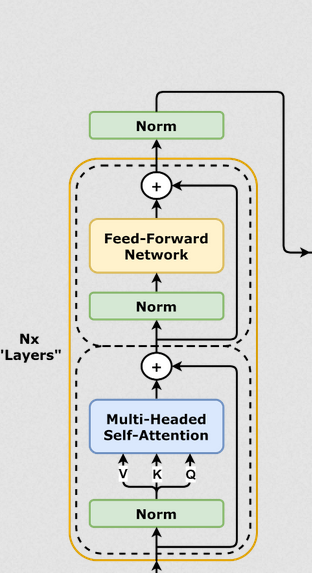

In [8]:
class EncoderBlock(nn.Module):
    
    def __init__(self,self_attention:MultiHeadAttention,feed_forward:FeedForward,dropout:float)-> None:
        super().__init__()
        
        self.self_attention = self_attention
        self.feed_forward=feed_forward
        self.dropout=nn.Dropout(dropout)
        
        self.residualConnection = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)])
        
    def forward(self,x,src_mask):
        x=self.residualConnection[0](x,lambda x: self.self_attention(x,x,x,src_mask))
        
        x=self.residualConnection[1](x,self.feed_forward)
        
        return x
    
    
class Encoder(nn.Module):
    
    def __init__(self,layers:nn.ModuleList)->None:
        super().__init__()
        
        self.layers=layers
        self.norm=LayerNormalization()
        
    def forward(self,x,mask):
        
        for layer in self.layers:
            x=layer(x,mask)
            
        return self.norm(x)

## 9.Decoder

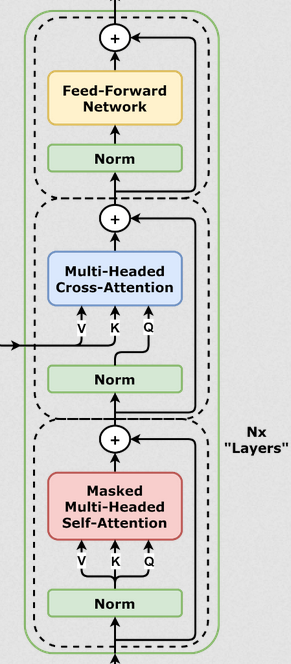

In [9]:
class DecoderBlock(nn.Module):
    def __init__(self,self_attention:MultiHeadAttention,cross_attention:MultiHeadAttention,feed_forward:FeedForward,dropout:float)->None:
        super().__init__()
        self.self_attention=self_attention
        self.cross_attention=cross_attention
        self.feed_forward=feed_forward
        self.dropout=nn.Dropout(dropout)
        self.residualConnection=nn.ModuleList([ResidualConnection(dropout)  for _ in range(3)])
        
    def forward(self,x,encoder_output,src_mask,tgt_mask):
        x=self.residualConnection[0](x,lambda x:self.self_attention(x,x,x,tgt_mask))
        
        x=self.residualConnection[1](x,lambda x:self.cross_attention(x,encoder_output,encoder_output,src_mask))
        
        x=self.residualConnection[2](x,self.feed_forward)
        
        return x
    
class Decoder(nn.Module):
    def __init__(self,layers:nn.ModuleList)->None:
        super().__init__()
        
        self.layers=layers
        self.norm=LayerNormalization()
        
    def forward(self,x,encoder_output,src_mask,tgt_mask):
        
        for layer in self.layers:
            x=layer(x,encoder_output,src_mask,tgt_mask)
            
        return self.norm(x)

## 10.Projection Layer

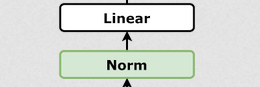

In [10]:
class ProjectionLayer(nn.Module):
    def __init__(self,d_model,vocab_size:int)->None:
        super().__init__()
        self.proj=nn.Linear(d_model,vocab_size)
        
    def forward(self,x):
        return torch.log_softmax(self.proj(x),dim=-1)        
        

## 11.Build a Transformer

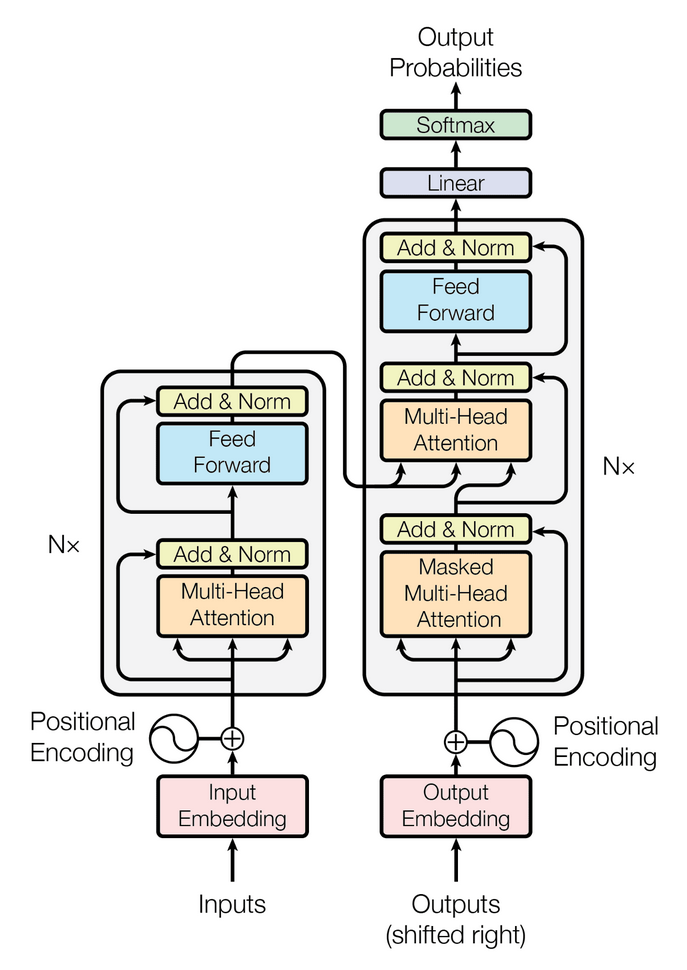

In [11]:
class Transformer(nn.Module):
    def __init__(self,encoder:Encoder,decoder:Decoder,src_embed:InputEmbedding,tgt_embed:InputEmbedding,src_pos:PositionEncoding,tgt_pos:PositionEncoding,projection_layer:ProjectionLayer)->None:
        super().__init__()
        self.encoder=encoder
        self.decoder=decoder
        self.src_embed=src_embed
        self.tgt_embed=tgt_embed
        self.src_pos=src_pos
        self.tgt_pos=tgt_pos
        self.projection_layer=projection_layer
        
    
    def encode(self, src, src_mask):
        src = self.src_pos(self.src_embed(src))
        return self.encoder(src, src_mask)

    def decode(self, tgt, memory, src_mask, tgt_mask):
        tgt = self.tgt_pos(self.tgt_embed(tgt))
        return self.decoder(tgt, memory, src_mask, tgt_mask)
    
    def project(self,x):
        return self.projection_layer(x)

In [16]:
def build_transformer(src_vocab_size : int,
                        tgt_vocab_size : int,
                        src_seq_len : int,
                        tgt_seq_len : int,
                        d_model : int=512,
                        N:int=6,
                        h:int=8,
                        dropout:float=0.1,
                        d_ff:int=2048)-> Transformer:
    src_embed=InputEmbedding(d_model,src_vocab_size)
    tgt_embed=InputEmbedding(d_model,tgt_vocab_size)
    
    src_pos=PositionEncoding(d_model,src_seq_len,dropout)
    tgt_pos=PositionEncoding(d_model,tgt_seq_len,dropout)
    
    encoder_blocks=[]
    
    for _ in range(N):
        encoder_self_attention=MultiHeadAttention(d_model,h,dropout)
        feed_forward=FeedForward(d_model,d_ff,dropout)
        encoder_block=EncoderBlock(encoder_self_attention,feed_forward,dropout)
        encoder_blocks.append(encoder_block)
    
    
    decoder_blocks=[]
    
    for _ in range(N):
        decoder_self_attention=MultiHeadAttention(d_model,h,dropout)
        decoder_cross_attention=MultiHeadAttention(d_model,h,dropout)
        feed_forward=FeedForward(d_model,d_ff,dropout)
        decoder_block=DecoderBlock(decoder_self_attention,decoder_cross_attention,feed_forward,dropout)
        decoder_blocks.append(decoder_block)
        
    encoder=Encoder(nn.ModuleList(encoder_blocks))
    decoder=Decoder(nn.ModuleList(decoder_blocks))
    
    projection_layer=ProjectionLayer(d_model,tgt_vocab_size)
    
    transformer=Transformer(
        encoder,
        decoder,
        src_embed,
        tgt_embed,
        src_pos,
        tgt_pos,
        projection_layer
    )
    
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    
    return transformer